# Exercise 4
Task:
- Implement DMDc as shown in Example 3.6
- Test script on data provided in handout 4
- Modify number of singular values and analyze effect on approximation quality





In [77]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from models import dmd, dmdc
from models import utils
from models import errors

In [78]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Task 1

a. Turn off the input in the file generate_data. Use the resulting simulation data to perform a DMD using the SVD. Herein adjust the rank r to achieve model order reduction

b. Set up the solution of the obtained linear rank-r linear system and compare the solution to the original solution from generate_data and the one for the full rank DMD.

In [36]:
@jax.jit
def piecewise_step(t: jax.Array) -> jax.Array:
    return (
        (t >= 1).astype(float)
        - 2 * (t >= 2).astype(float)
        -     (t >= 3).astype(float)
        + 4 * (t >= 4).astype(float)
        - 2 * (t >= 6).astype(float)
    )

In [88]:
# Generate Data
z = jnp.linspace(0, 1, 201)
t = jnp.linspace(0, 10, 1001)
u = piecewise_step(t)

p = utils.PDEParams(
    d=0.45, c=-1.0, fun=lambda x, dx, z, t: -0.2 * x + 10 * jnp.sin(x), t=t, u=u, z=z
)

x, z, t = utils.solve_pde_implicit(p)
x = jnp.array(x)

x_ = x[:-1].T       
x_prime = x[1:].T
x_0 = x_[:, 0]   


display("X shape:", x_.shape)
display("X Prime shape:", x_prime.shape)
display("U shape:", u.shape)    

'X shape:'

(201, 1000)

'X Prime shape:'

(201, 1000)

'U shape:'

(1001,)

In [89]:
r, a, phi, lam = dmd.optimize(x_,x_prime, t,(1,20))
result = dmd.simulate(phi, lam,x_0,t)
result = result.real
display(r)

16

In [90]:
u = u[:x.shape[0]-1].reshape(1,-1)
r_c, a_c, b_c, phi_c, lam_c = dmdc.optimize(x_,x_prime,u, t, (1,20))
display(r_c)

1

In [91]:
result_c = dmdc.simulate(x_0, u.T, a_c, b_c, phi_c)
result_c = result_c.real

In [92]:
display(errors._mean_absolute_error(x, result))
display(errors._mean_absolute_error(x, result_c))

Array(0.03588776, dtype=float32)

Array(0.7550554, dtype=float32)

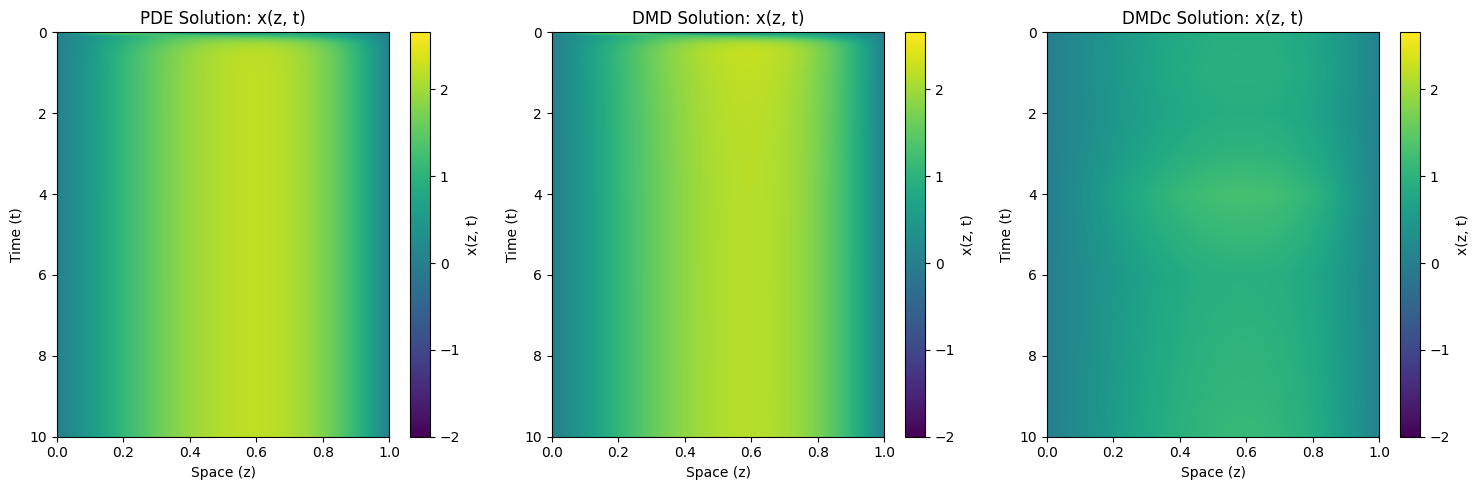

In [93]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x, extent=[z[0], z[-1], t[-1], t[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Space (z)')
plt.ylabel('Time (t)')
plt.title('PDE Solution: x(z, t)')

plt.subplot(1, 3, 2)
plt.imshow(result, extent=[z[0], z[-1], t[-1], t[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Space (z)')
plt.ylabel('Time (t)')
plt.title('DMD Solution: x(z, t)')

plt.subplot(1, 3, 3)
plt.imshow(result_c, extent=[z[0], z[-1], t[-1], t[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Space (z)')
plt.ylabel('Time (t)')
plt.title('DMDc Solution: x(z, t)')

plt.tight_layout()
plt.show()




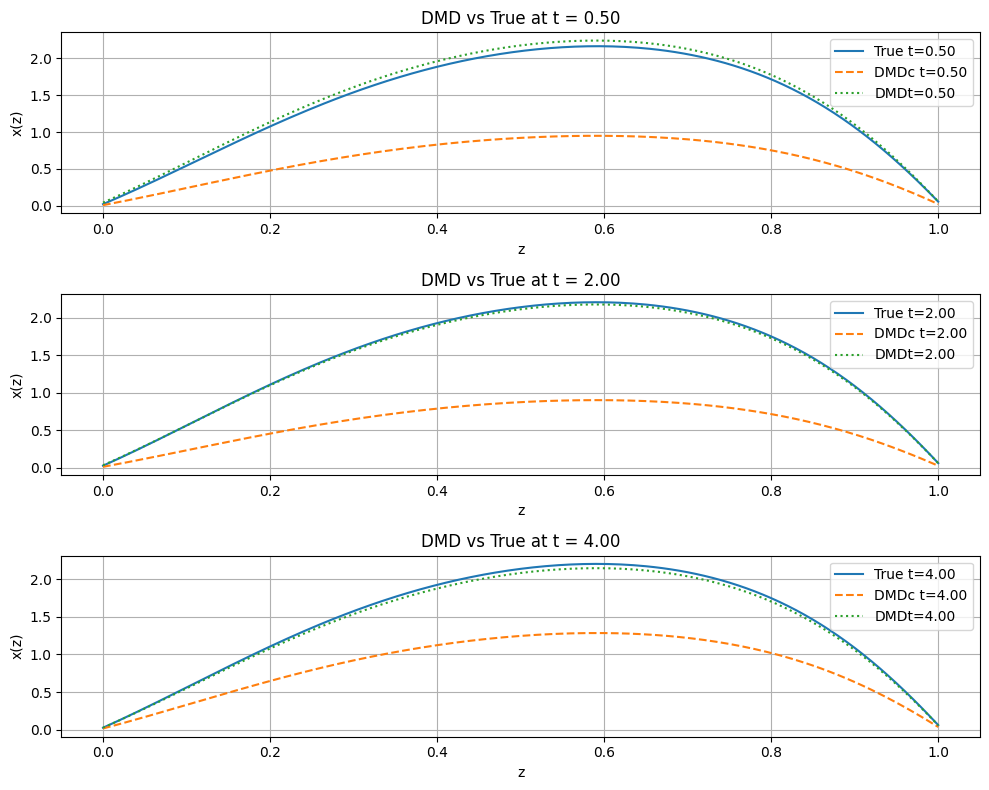

In [94]:
plt.figure(figsize=(10, 8))
for index, i in enumerate([50, 200, 400]):
    plt.subplot(3, 1, index +1)
    plt.plot(z, x[i], label=f"True t={t[i]:.2f}")
    plt.plot(z, result_c.T[:, i], "--", label=f"DMDc t={t[i]:.2f}")
    plt.plot(z, result.T[:, i], ":", label=f"DMDt={t[i]:.2f}")
    plt.xlabel("z")
    plt.ylabel("x(z)")
    plt.legend()
    plt.title("DMD vs True at t = {:.2f}".format(t[i]))
    plt.grid(True)
plt.tight_layout()
plt.show()
